# ShikshaSathi AI – Behaviour-Based Student Learning Analysis

This notebook demonstrates an end-to-end AI system that analyzes **how students learn**, not just whether they answer correctly.

The system:
- Ingests raw student interaction data (CSV)
- Performs behavioural feature engineering
- Trains a lightweight Deep Neural Network (DNN)
- Generates student-wise learning insights
- Visualizes results for teachers
- Works offline using TensorFlow Lite

This prototype is designed for **classroom readiness and hackathon demonstration**.



## Step 1: Import Required Libraries

We import libraries for:
- Data handling (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Machine learning (TensorFlow)
- Preprocessing and evaluation (scikit-learn)

Each library plays a specific role in the AI pipeline.


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

## Step 2: Dataset – Simulated Student Interaction Data

This dataset simulates a real classroom scenario where:
- 5 students attempt 5 questions each
- Each row represents **one question attempt**
- Behavioural signals are captured instead of only answers

Columns:
- student_id: Identifies the student
- question_id: Identifies the question
- answer_correct: 1 if correct, 0 if incorrect
- time_taken: Time taken to answer (seconds)
- attempts: Number of attempts made
- hint_used: Whether a hint was used
- difficalty: Identifies the difficalty of the question

In [113]:
from google.colab import files
uploaded = files.upload()

In [114]:
df=pd.read_csv("shiksha (2).csv")
df

,student_id,question_id,answer_correct,time_taken,attempts,hint_used
0,S1,Q1,1,12,1,0
1,S1,Q2,1,15,1,0
2,S1,Q3,0,28,2,1
3,S1,Q4,1,14,1,0
4,S1,Q5,1,13,1,0
...,...,...,...,...,...,...
95,S10,Q6,0,47,3,1
96,S10,Q7,1,36,2,0
97,S10,Q8,0,48,3,1
98,S10,Q9,0,50,3,1


## Step 3: Understanding Raw Student Behaviour

Before applying AI, we visualize raw behavioural data to:
- Understand response time patterns
- Identify struggle through repeated attempts

These visualizations help validate that the collected data reflects realistic learning behaviour.


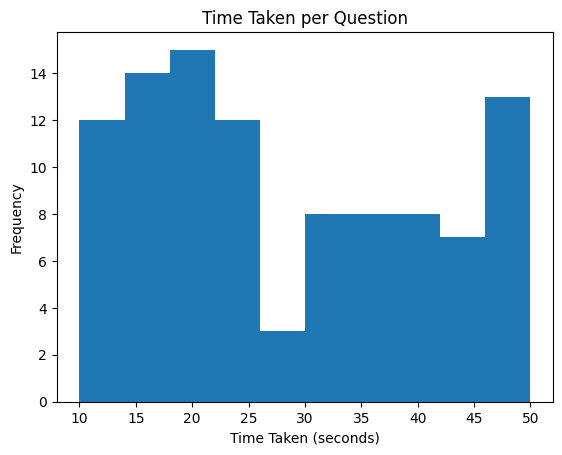

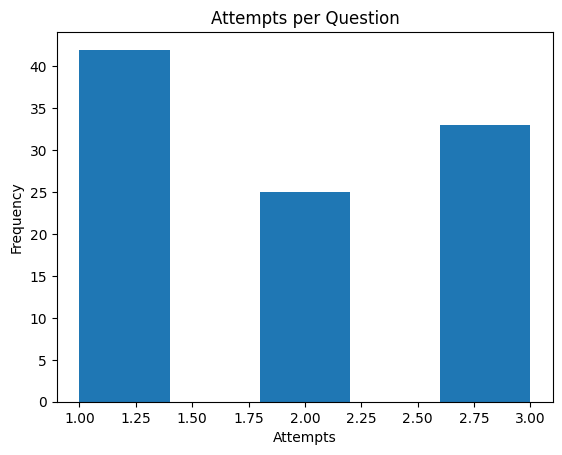

In [115]:
plt.figure()
plt.hist(df["time_taken"], bins=10)
plt.xlabel("Time Taken (seconds)")
plt.ylabel("Frequency")
plt.title("Time Taken per Question")
plt.show()
plt.figure()
plt.hist(df["attempts"], bins=5)
plt.xlabel("Attempts")
plt.ylabel("Frequency")
plt.title("Attempts per Question")
plt.show()

## Step 4: Feature Engineering – Student-Wise Learning Profiles

Raw question-level data is converted into **student-level learning profiles**.

For each student, we compute:
- Accuracy: Overall correctness
- Average Time: Speed of response
- Average Attempts: Struggle indicator
- Hint Ratio: Dependency on help
- Consistency (optional): Stability of performance

This step transforms raw logs into meaningful AI-ready features.

In [116]:
student_features = (
    df.groupby("student_id")
    .apply(lambda x: pd.Series({
        "accuracy": x["answer_correct"].mean(),
        "avg_time": x["time_taken"].mean(),
        "avg_attempts": x["attempts"].mean(),
        "hint_ratio": x["hint_used"].mean(),
        "consistency": 1 - x["answer_correct"].std()
    }))
    .reset_index()
)
student_features


/tmp/ipython-input-2891620415.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,student_id,accuracy,avg_time,avg_attempts,hint_ratio,consistency
0,S1,0.8,16.9,1.2,0.2,0.578363
1,S10,0.2,45.7,2.8,0.8,0.578363
2,S2,0.5,30.4,2.5,0.5,0.472954
3,S3,1.0,11.8,1.0,0.0,1.000000
4,S4,0.2,43.3,2.8,0.8,0.578363
5,S5,0.6,23.9,1.4,0.4,0.483602
6,S6,0.2,37.9,2.8,0.8,0.578363
7,S7,1.0,15.9,1.0,0.0,1.000000
8,S8,0.5,29.0,2.4,0.5,0.472954
9,S9,0.8,22.7,1.2,0.2,0.578363


## Step 5: Feature Distribution Analysis

We visualize engineered features to:
- Ensure values are well-distributed
- Detect anomalies
- Validate feature quality before model training

This step improves trust in the AI pipeline.


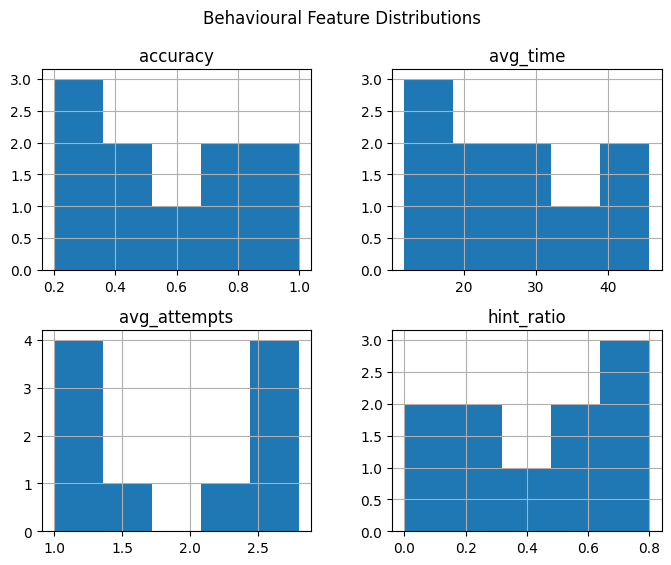

In [117]:
student_features[["accuracy","avg_time","avg_attempts","hint_ratio"]].hist(
    figsize=(8,6), bins=5
)
plt.suptitle("Behavioural Feature Distributions")
plt.show()


## Step 6: Label Assignment (Training Purpose Only)

For model training, we assign learning-level labels:
- 0 → Needs Help
- 1 → Average
- 2 → Strong

These labels are rule-based and used **only to train and evaluate the model**.
In real deployment, the AI predicts these labels automatically.


In [118]:
def assign_label(row):
    if row["accuracy"] >= 0.75 and row["hint_ratio"] < 0.3:
        return 2
    elif row["accuracy"] >= 0.4:
        return 1
    else:
        return 0

student_features["label"] = student_features.apply(assign_label, axis=1)
student_features


,student_id,accuracy,avg_time,avg_attempts,hint_ratio,consistency,label
0,S1,0.8,16.9,1.2,0.2,0.578363,2
1,S10,0.2,45.7,2.8,0.8,0.578363,0
2,S2,0.5,30.4,2.5,0.5,0.472954,1
3,S3,1.0,11.8,1.0,0.0,1.000000,2
4,S4,0.2,43.3,2.8,0.8,0.578363,0
5,S5,0.6,23.9,1.4,0.4,0.483602,1
6,S6,0.2,37.9,2.8,0.8,0.578363,0
7,S7,1.0,15.9,1.0,0.0,1.000000,2
8,S8,0.5,29.0,2.4,0.5,0.472954,1
9,S9,0.8,22.7,1.2,0.2,0.578363,2


## Step 7: Feature Normalization

Features are normalized to a 0–1 range to:
- Prevent dominance of large-scale features (e.g., time)
- Improve neural network stability
- Ensure fair learning across features


In [119]:
scaler = MinMaxScaler()

feature_cols = ["accuracy", "avg_time", "avg_attempts", "hint_ratio"]

student_features_scaled = student_features.copy()
student_features_scaled[feature_cols] = scaler.fit_transform(
    student_features[feature_cols]
)

student_features_scaled


,student_id,accuracy,avg_time,avg_attempts,hint_ratio,consistency,label
0,S1,0.750,0.150442,0.111111,0.250,0.578363,2
1,S10,0.000,1.000000,1.000000,1.000,0.578363,0
2,S2,0.375,0.548673,0.833333,0.625,0.472954,1
3,S3,1.000,0.000000,0.000000,0.000,1.000000,2
4,S4,0.000,0.929204,1.000000,1.000,0.578363,0
5,S5,0.500,0.356932,0.222222,0.500,0.483602,1
6,S6,0.000,0.769912,1.000000,1.000,0.578363,0
7,S7,1.000,0.120944,0.000000,0.000,1.000000,2
8,S8,0.375,0.507375,0.777778,0.625,0.472954,1
9,S9,0.750,0.321534,0.111111,0.250,0.578363,2


## Step 8: Train-Test Split

The dataset is split into:
- Training set: Used to learn patterns
- Test set: Used to evaluate generalization

This prevents memorization and ensures fair evaluation.


In [120]:
X = student_features_scaled[feature_cols].values
y = student_features_scaled["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Step 9: Deep Neural Network (DNN) Architecture

We use a lightweight feedforward neural network with:
- Input layer: Behavioural features
- Two hidden layers (ReLU activation)
- Output layer with Softmax for 3 learning levels

This architecture balances:
- Expressiveness
- Explainability
- Offline deployment readiness


In [121]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu", input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243 (972.00 B)

 Trainable params: 243 (972.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 10: Model Training

The model is trained using:
- Adam optimizer
- Sparse categorical cross-entropy loss

During training, the model learns to map behavioural patterns to learning levels.


In [122]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2857 - loss: 1.2329 - val_accuracy: 0.3333 - val_loss: 0.9277
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1429 - loss: 1.2091 - val_accuracy: 0.3333 - val_loss: 0.9307
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1429 - loss: 1.2074 - val_accuracy: 0.3333 - val_loss: 0.9341
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1429 - loss: 1.2292 - val_accuracy: 0.3333 - val_loss: 0.9379
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1429 - loss: 1.1785 - val_accuracy: 0.3333 - val_loss: 0.9414
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1429 - loss: 1.2288 - val_accuracy: 0.3333 - val_loss: 0.9442
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0000e+00 - loss: 1.2056 - val_accuracy: 0.3333 - val_loss: 0.9463
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2857 - loss: 1.1556 - val_accuracy: 0.0000e+00 - val_loss: 

## Step 11: Training Performance Visualization

Training and validation accuracy are plotted to:
- Confirm learning progress
- Detect overfitting or underfitting

This ensures model reliability.


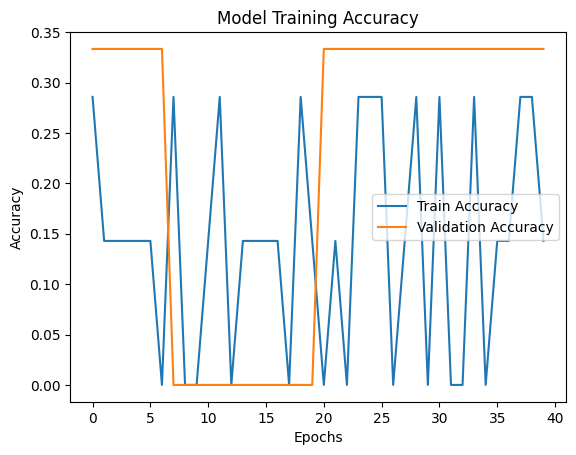

In [123]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training Accuracy")
plt.legend()
plt.show()

## Step 12: Model Evaluation

We evaluate the model using:
- Accuracy
- Precision and Recall
- Confusion Matrix

Special emphasis is placed on correctly identifying students who need help.


In [124]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[1, 0],
       [2, 0]])

## Step 13: TensorFlow Lite Conversion (Offline AI)

The trained model is converted to TensorFlow Lite to:
- Enable offline inference
- Support low-resource devices
- Ensure privacy-preserving deployment

This makes the system classroom-ready.


In [125]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open("shikshasathi_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model created")

Saved artifact at '/tmp/tmphnk0rcmq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135143197155472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143197154320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143197155088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143197153936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143197157776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143197154704: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model created


## Step 14: Offline Inference Using TensorFlow Lite

Predictions are performed using the TFLite interpreter, simulating:
- Real device execution
- No cloud dependency
- Edge-based AI inference


In [126]:
interpreter = tf.lite.Interpreter(model_path="shikshasathi_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Step 15: Student-Wise Learning Analysis

The AI produces:
- Predicted learning level
- Confidence score
- Explainable reasoning (optional)
- Risk flag (optional)

This output is directly usable by teachers.


In [127]:
all_predictions = []
all_confidences = []

for i in range(X.shape[0]):
    # Get a single sample and reshape it to (1, 4)
    input_data = X[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]["index"])
    all_predictions.append(np.argmax(output, axis=1)[0])
    all_confidences.append(np.max(output, axis=1)[0])

predicted = np.array(all_predictions)
confidence = np.array(all_confidences)

## Step 16: Student-Wise Learning Level Visualization

Each student is plotted on a learning scale:
- 0 → Needs Help
- 1 → Average
- 2 → Strong

Bubble size or color represents prediction confidence, enabling quick teacher insights.


In [128]:
label_map = {0: "Needs Help", 1: "Average", 2: "Strong"}

student_features_scaled["predicted_level"] = [
    label_map[i] for i in predicted
]
student_features_scaled["confidence"] = confidence.round(2)

def explain_prediction(row):
    reasons = []
    if row["accuracy"] < 0.5:
        reasons.append("Low accuracy")
    if row["avg_time"] > 0.6:
        reasons.append("High time taken")
    if row["avg_attempts"] > 0.6:
        reasons.append("Multiple attempts")
    if row["hint_ratio"] > 0.5:
        reasons.append("High hint usage")
    return ", ".join(reasons) if reasons else "Consistent learning behaviour"

student_features_scaled["explanation"] = student_features_scaled.apply(
    explain_prediction, axis=1
)

final_report = student_features_scaled[
    ["student_id", "predicted_level", "confidence", "explanation"]
]

final_report

,student_id,predicted_level,confidence,explanation
0,S1,Needs Help,0.36,Consistent learning behaviour
1,S10,Needs Help,0.44,"Low accuracy, High time taken, Multiple attemp..."
2,S2,Needs Help,0.42,"Low accuracy, Multiple attempts, High hint usage"
3,S3,Needs Help,0.34,Consistent learning behaviour
4,S4,Needs Help,0.44,"Low accuracy, High time taken, Multiple attemp..."
5,S5,Needs Help,0.39,Consistent learning behaviour
6,S6,Needs Help,0.43,"Low accuracy, High time taken, Multiple attemp..."
7,S7,Needs Help,0.34,Consistent learning behaviour
8,S8,Needs Help,0.41,"Low accuracy, Multiple attempts, High hint usage"
9,S9,Needs Help,0.37,Consistent learning behaviour


## Conclusion

ShikshaSathi AI demonstrates how behavioural learning data can be transformed into
actionable, explainable, and offline AI insights.

The system prioritizes:
- Early identification of struggling students
- Responsible and explainable AI
- Practical classroom deployment

This prototype showcases a scalable foundation for real-world educational AI systems.


/tmp/ipython-input-2534389601.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_report["level_numeric"] = final_report["predicted_level"].map(level_to_num)


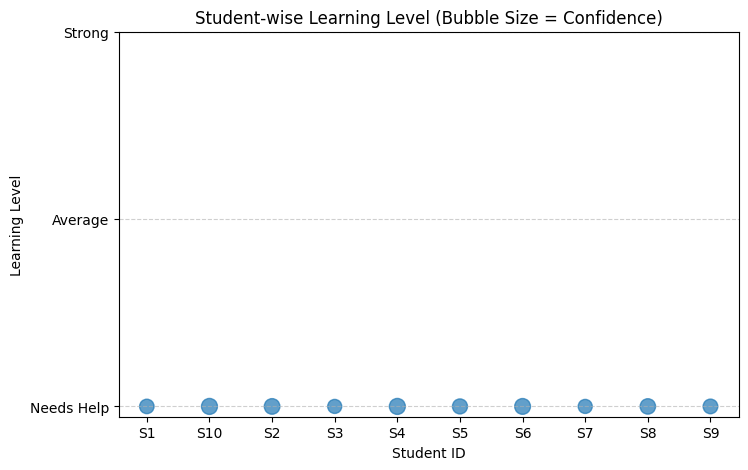

In [129]:
level_to_num = {
    "Needs Help": 0,
    "Average": 1,
    "Strong": 2
}

final_report["level_numeric"] = final_report["predicted_level"].map(level_to_num)

plt.figure(figsize=(8,5))
plt.scatter(
    final_report["student_id"],
    final_report["level_numeric"],
    s=final_report["confidence"]*300,
    alpha=0.7
)
plt.yticks([0,1,2], ["Needs Help","Average","Strong"])
plt.xlabel("Student ID")
plt.ylabel("Learning Level")
plt.title("Student-wise Learning Level (Bubble Size = Confidence)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [130]:
final_report["risk_flag"] = final_report["confidence"] < 0.5
final_report

/tmp/ipython-input-2616169131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_report["risk_flag"] = final_report["confidence"] < 0.5


,student_id,predicted_level,confidence,explanation,level_numeric,risk_flag
0,S1,Needs Help,0.36,Consistent learning behaviour,0,True
1,S10,Needs Help,0.44,"Low accuracy, High time taken, Multiple attemp...",0,True
2,S2,Needs Help,0.42,"Low accuracy, Multiple attempts, High hint usage",0,True
3,S3,Needs Help,0.34,Consistent learning behaviour,0,True
4,S4,Needs Help,0.44,"Low accuracy, High time taken, Multiple attemp...",0,True
5,S5,Needs Help,0.39,Consistent learning behaviour,0,True
6,S6,Needs Help,0.43,"Low accuracy, High time taken, Multiple attemp...",0,True
7,S7,Needs Help,0.34,Consistent learning behaviour,0,True
8,S8,Needs Help,0.41,"Low accuracy, Multiple attempts, High hint usage",0,True
9,S9,Needs Help,0.37,Consistent learning behaviour,0,True
